# Project
# Import packages and symbolic computation tools

In [1]:
import sympy as sp
from sympy import symbols, pprint
from sympy import sin, cos, asin, acos, pi, atan2, sqrt
from sympy import Matrix
from sympy.utilities.lambdify import lambdify
import numpy as np

from IPython import display # for the animation
import matplotlib as mpl
#mpl.use('Qt5Agg')

import matplotlib.pyplot as plt
plt.ion()
from scipy.optimize import minimize
from scipy.optimize import fsolve

import time
import math
# odrive tools
import odrive
import odrive.utils
import odrive.enums
from odrive.enums import *

## Motor constants
K_T = 0.0285;               # Nm / A
peak_amp = 30;              # A
peak_torque = K_T * peak_amp; # Nm

l1 = 0.09;                  # m 
l2 = 0.16;                  # m
w = 0.07;                   # m


# solve jacobian of constraint equation
(thetaL_sym, 
 thetaR_sym) = sp.symbols("""thetaL_sym 
                            thetaR_sym """, real = True)


def T(theta, x, y):
    """
    Function to return an arbitrary transformation matrix 
    This is for sympy symbolic calculation
    """
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta), x], 
                      [sp.sin(theta), sp.cos(theta), y],
                      [0, 0, 1]])

def sym_to_np(T):
    return np.array(T).astype(np.float64)

# draw full linkages used in IK  
#mpl.use('Qt5Agg')
def internal_angles(thetaR, thetaL, l1 = l1, l2 = l2, w = w):
    def sys(x): 
        return (w + l1*np.cos(thetaR) + l2*np.cos(x[0]) - l1*np.cos(thetaL) - l2*np.cos(x[1]),
                l1*np.sin(thetaR) + l2*np.sin(x[0]) - l1*np.sin(thetaL) - l2*np.sin(x[1]))

    alphaR, alphaL = fsolve(sys, (np.pi/2, np.pi/2))
    
    alphaR = alphaR % (2*np.pi)
    alphaL = alphaL % (2*np.pi)
        
    # Copmute FK for checking
    x = w/2 + l1*np.cos(thetaR) + l2*np.cos(alphaR);
    y = l1*np.sin(thetaR) + l2*np.sin(alphaR);

    return (alphaR, alphaL, x, y)
def draw_robot_IK(thetaR, thetaL, link1 = l1, link2 = l2, width = w, ax = False):
    
    # Solve for internal angles
    (alphaR, alphaL, x, y) = internal_angles(thetaR, thetaL)

    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        return(x, y)

    if ax == False:
        ax = plt.gca()
        ax.cla()
    ax.plot(-width/2, 0, 'ok')
    ax.plot(width/2, 0, 'ok')
    ax.plot([-width/2, 0], [0, 0], 'k')
    ax.plot([width/2, 0], [0, 0], 'k')
    ax.plot(-width/2 + np.array([0, link1*np.cos(thetaL)]), [0, link1*np.sin(thetaL)], 'k')
    ax.plot(width/2 + np.array([0, link1*np.cos(thetaR)]), [0, link1*np.sin(thetaR)], 'k')
    ax.plot(-width/2 + link1*np.cos(thetaL) + np.array([0, link2*np.cos(alphaL)]), \
             link1*np.sin(thetaL) + np.array([0, link2*np.sin(alphaL)]), 'k');
    ax.plot(width/2 + link1*np.cos(thetaR) + np.array([0, link2*np.cos(alphaR)]), \
             np.array(link1*np.sin(thetaR) + np.array([0, link2*np.sin(alphaR)])), 'k');
    ax.plot(x, y, 'ro');
    ax.axis([-.3,.3,-.1,.3])

## FK, IK, Trajectory

In [2]:
x_r = -w/2 + l1*sp.cos(thetaR_sym)
x_l = w/2 + l1*sp.cos(thetaL_sym)

y_r = l1*sp.sin(thetaR_sym)
y_l = l1*sp.sin(thetaL_sym)

theta3_sym = sp.atan2(y_l - y_r, x_l - x_r)
L = sp.sqrt((x_l - x_r)**2 + (y_l - y_r)**2)
 
# for cartesian
FK = T(thetaL_sym, w/2, 0)@T((sp.pi - thetaL_sym + theta3_sym), l1, 0)@sp.Matrix([L/2, -sp.sqrt(l2**2 - (L/2)**2), 1])
FK = FK[:2,:]
FK_fast = lambdify((thetaR_sym, thetaL_sym), FK) # FK_fast(x,y)
J = FK.jacobian([thetaR_sym, thetaL_sym]).evalf()
J_fast = lambdify((thetaR_sym, thetaL_sym), J) # J_fast(x,y)


# for polar
FK_r=(FK[0]**2+FK[1]**2)**0.5 # radious
FK_theta=sp.atan2(FK[0],FK[1])
FK_polar = sp.Matrix([[FK_r],[FK_theta]])
FK_polar_fast = lambdify((thetaR_sym, thetaL_sym), FK_polar) 
J_polar = FK_polar.jacobian([thetaR_sym, thetaL_sym]).evalf() 
J_polar_fast = lambdify((thetaR_sym, thetaL_sym), J_polar) # J=(r/tR, theta/tR; r/tL, theta/L)


# IK, xyz position, Jacobian function
def IK_constraint_eqn(x, x_pt, y_pt, l1, l2, w):
    theta_R = x[0]
    theta_L = x[1]
    return (l1**2 - l2**2 + (x_pt - w/2)**2 + y_pt**2 - 2*l1 * (y_pt * np.sin(theta_R) + (x_pt - w/2)*np.cos(theta_R)),
            l1**2 - l2**2 + (x_pt + w/2)**2 + y_pt**2 - 2*l1 * (y_pt * np.sin(theta_L) + (x_pt + w/2)*np.cos(theta_L)))

def IK_5_link(x, y, l1 = l1, l2 = l2, w = w):
    
    def leg_wide(var):
        return np.linalg.norm([var[1] - np.pi, var[0]])
    
    def x_constraint_equation(var):
        # should be equal to zero when the 
        return l1**2 - l2**2 + (x - w/2)**2 + y**2 - 2*l1*(y*np.sin(var[0]) + (x - w/2)*np.cos(var[0]))

    def y_constraint_equation(var):
        return l1**2 - l2**2 + (x + w/2)**2 + y**2 - 2*l1*(y*np.sin(var[1]) + (x + w/2)*np.cos(var[1]))

    
    res = minimize(leg_wide, (0.1, 9*np.pi/10), method="SLSQP", constraints= ({"type": "eq", "fun": x_constraint_equation}, 
                                                                               {"type": "eq", "fun": y_constraint_equation}))
    
    return (res, np.linalg.norm([x_constraint_equation(res.x), y_constraint_equation(res.x)]))

# input 4 points, return xy position,thetaR,thetaL,time
def gaits_points(p_on,p_off,p_stance,p_swing,T,d,N):
    x_on=p_on[0]
    y_on=p_on[1]
    x_off=p_off[0]
    y_off=p_off[1]
    x_swing=p_swing[0]
    y_swing=p_swing[1]
    x_stance=p_stance[0]
    y_stance=p_stance[1]
    
    x = np.array([x_on ,x_swing ,x_off])
    y = np.array([y_on ,y_swing ,y_off])
    z = np.poly1d(np.polyfit(x, y, 2))
    N_stance = int(N * (d))
    N_swing = int(N * (1-d))
    
    x_s = np.array([x_on ,x_stance,x_off])
    y_s = np.array([y_on ,y_stance ,y_off])
    z_s = np.poly1d(np.polyfit(x_s, y_s, 2))
 
    x_stance = np.linspace(x_on,x_off,N_stance)
    y_stance = np.polyval(z_s,x_stance)
    x_swing = np.linspace(x_off ,x_on , N_swing)
    y_swing = np.polyval(z,x_swing)
    x_desired = np.append(x_stance,x_swing)
    y_desired = np.append(y_stance,y_swing)
    
    theta_desired = []
    thetaR_desired = []
    thetaL_desired = []
    for i in range(N):
        theta_desired = fsolve(lambda x: IK_constraint_eqn(x, x_desired[i], y_desired[i], l1, l2,w), (0,np.pi))
        thetaR_desired.append(theta_desired[0])
        thetaL_desired.append(theta_desired[1])
    t_desired = np.linspace(0,T,N)
    return (x_desired,y_desired,thetaL_desired,thetaR_desired,t_desired)

# input 4 points, return xy position,thetaR,thetaL,time
def gaits_points_rise(p_stance,p_swing,N):
    x_swing=p_swing[0]
    y_swing=p_swing[1]
    x_stance=p_stance[0]
    y_stance=p_stance[1]
 
    x_desired = np.linspace(x_stance,x_swing,N)
    y_desired = np.linspace(y_stance,y_swing,N)
    
    theta_desired = []
    thetaR_desired = []
    thetaL_desired = []
    for i in range(N):
        theta_desired = fsolve(lambda x: IK_constraint_eqn(x, x_desired[i], y_desired[i], l1, l2,w), (0,np.pi))
        thetaR_desired.append(theta_desired[0])
        thetaL_desired.append(theta_desired[1])
    t_desired = np.linspace(0,N,N)
    return (x_desired,y_desired,thetaL_desired,thetaR_desired,t_desired)

# Connect to Left Odrive

In [3]:
odrv_Left = odrive.find_any(serial_number="20593884304E") # Deimal:35567572365390 Hex:20593884304E
if odrv_Left is not None:
    print('\t Connected!')
    print('\t Left Odrive serial {}'.format(odrv_Left.serial_number))
    print('\t Left m0 calibrated: {}'.format(odrv_Left.axis0.motor.is_calibrated))
    print('\t Left m1 calibrated: {}'.format(odrv_Left.axis1.motor.is_calibrated))       
else:
    print('\t Not connected')

	 Connected!
	 Left Odrive serial 35567572365390
	 Left m0 calibrated: False
	 Left m1 calibrated: False


# Connect to Right Odrive

In [4]:
odrv_Right = odrive.find_any(serial_number="306539533235") # Deimal:53211311583797 Hex:306539533235
if odrv_Right is not None:
    print('\t Connected!')
    print('\t Right Odrive serial {}'.format(odrv_Right.serial_number))
    print('\t Right m0 calibrated: {}'.format(odrv_Right.axis0.motor.is_calibrated))
    print('\t Right m1 calibrated: {}'.format(odrv_Right.axis1.motor.is_calibrated))    
else:
    print('Not connected')

	 Connected!
	 Right Odrive serial 53211311583797
	 Right m0 calibrated: False
	 Right m1 calibrated: False


# Configure output limits

In [5]:
odrive.utils.dump_errors(odrv_Left,True)
odrive.utils.dump_errors(odrv_Right,True)
curr_limit = 15 #A
odrv_Left.axis0.motor.config.current_lim = curr_limit
odrv_Left.axis1.motor.config.current_lim = curr_limit
odrv_Right.axis0.motor.config.current_lim = curr_limit
odrv_Right.axis1.motor.config.current_lim = curr_limit
odrv_Left.axis0.controller.config.vel_limit = 1000000
odrv_Left.axis1.controller.config.vel_limit = 1000000
odrv_Right.axis0.controller.config.vel_limit = 1000000
odrv_Right.axis1.controller.config.vel_limit = 1000000
current_limit_Left = (curr_limit, curr_limit)
current_limit_Right = (curr_limit, curr_limit)
odrv_Left.axis0.controller.config.pos_gain = 20.0 #[(counts/s) / counts]
odrv_Left.axis1.controller.config.pos_gain = 20.0 #[(counts/s) / counts]
odrv_Right.axis0.controller.config.pos_gain = 20.0 #[(counts/s) / counts]
odrv_Right.axis1.controller.config.pos_gain = 20.0 #[(counts/s) / counts]

axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


# Left Odrive Calbration

In [6]:
odrv_Left.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv_Left.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
time.sleep(15)
print('\t Left m0 calibration result: {}\r\n'.format(odrv_Left.axis0.motor.is_calibrated), 
      '\t Left m1 calibration result: {}'.format(odrv_Left.axis1.motor.is_calibrated))

	 Left m0 calibration result: True
 	 Left m1 calibration result: True


# Right Odrive Calbration

In [7]:
odrv_Right.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv_Right.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
time.sleep(15)
print('\t Right m0 calibration result: {}\r\n'.format(odrv_Right.axis0.motor.is_calibrated), 
      '\t Right m1 calibration result: {}'.format(odrv_Right.axis1.motor.is_calibrated))

	 Right m0 calibration result: True
 	 Right m1 calibration result: True


# Legs on
# Define Left Leg home position (m1=0, m0=180)

In [8]:
# Read encoder value
Left_m0_home_pos = odrv_Left.axis0.encoder.pos_estimate
Left_m1_home_pos = odrv_Left.axis1.encoder.pos_estimate
# convert encoder value to radians
Left_thetaR_home = -((Left_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
Left_thetaL_home = -((Left_m1_home_pos) / 8192 * 2 * np.pi)
# print('\t Left m0(R) home command: {:.2f}'.format(Left_m0_home_pos), 
#       '\t Left m1(L) home command: {:.2f}'.format(Left_m1_home_pos))
print('\t Left m0(R) home angle(degree): {:.2f}'.format(np.degrees(Left_thetaR_home)), 
      '\t Left m1(L) home angle(degree): {:.2f}'.format(np.degrees(Left_thetaL_home)))

	 Left m0(R) home angle(degree): 160.04 	 Left m1(L) home angle(degree): -1.37


# Define Right Leg home position (m1=0, m0=180)

In [9]:
# Read encoder value
Right_m0_home_pos = odrv_Right.axis0.encoder.pos_estimate
Right_m1_home_pos = odrv_Right.axis1.encoder.pos_estimate
# convert encoder value to radians
Right_thetaR_home = -((Right_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
Right_thetaL_home = -((Right_m1_home_pos) / 8192 * 2 * np.pi)
# print('\t Right m0(R) home command: {:.2f}'.format(Right_m0_home_pos), 
#       '\t Right m1(L) home command: {:.2f}'.format(Right_m1_home_pos))
print('\t Right m0(R) home angle(degree): {:.2f}'.format(np.degrees(Right_thetaR_home)), 
      '\t Right m1(L) home angle(degree): {:.2f}'.format(np.degrees(Right_thetaL_home)))

	 Right m0(R) home angle(degree): 274.56 	 Right m1(L) home angle(degree): -81.05


# Define equlibrium Left toe position

In [10]:
# Read encoder value
Left_m0_eq_pos = odrv_Left.axis0.encoder.pos_estimate
Left_m1_eq_pos = odrv_Left.axis1.encoder.pos_estimate
# convert encoder value to radians
Left_thetaR_eq = - ((Left_m0_eq_pos - Left_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
Left_thetaL_eq = - ((Left_m1_eq_pos - Left_m1_home_pos) / 8192 * 2 * np.pi)
# print('\t Left m0(R) eq command: {:.2f}'.format(Left_m0_eq_pos), 
#       '\t Left m1(L) eq command: {:.2f}'.format(Left_m1_eq_pos))
print('\t Left m0(R) eq angle(degree): {:.2f}'.format(np.degrees(Left_thetaR_eq)), 
      '\t Left m1(L) eq angle(degree): {:.2f}'.format(np.degrees(Left_thetaL_eq)))

	 Left m0(R) eq angle(degree): 156.80 	 Left m1(L) eq angle(degree): 23.95


# Define equlibrium Right toe position

In [11]:
# Read encoder value
Right_m0_eq_pos = odrv_Right.axis0.encoder.pos_estimate
Right_m1_eq_pos = odrv_Right.axis1.encoder.pos_estimate
# convert encoder value to radians
Right_thetaR_eq = - ((Right_m0_eq_pos - Right_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
Right_thetaL_eq = - ((Right_m1_eq_pos - Right_m1_home_pos) / 8192 * 2 * np.pi)
# print('\t Right m0(R) eq command: {:.2f}'.format(Right_m0_eq_pos), 
#       '\t Right m1(L) eq command: {:.2f}'.format(Right_m1_eq_pos))
print('\t Right m0(R) eq angle(degree): {:.2f}'.format(np.degrees(Right_thetaR_eq)), 
      '\t Right m1(L) eq angle(degree): {:.2f}'.format(np.degrees(Right_thetaL_eq)))

	 Right m0(R) eq angle(degree): 130.09 	 Right m1(L) eq angle(degree): 4.58


# Define movement function

In [12]:
# input 4 theta value, return xy position,thetaR,thetaL,time
def move_measure(Left_pos_R_temp,Left_pos_L_temp,Right_pos_R_temp,Right_pos_L_temp):
    odrv_Left.axis0.controller.set_pos_setpoint(Left_pos_R_temp,0,0)
    odrv_Left.axis1.controller.set_pos_setpoint(Left_pos_L_temp,0,0)
    odrv_Right.axis0.controller.set_pos_setpoint(Right_pos_R_temp,0,0)
    odrv_Right.axis1.controller.set_pos_setpoint(Right_pos_L_temp,0,0)
    # position measurement
    Left_R_encoder_pos = odrv_Left.axis0.encoder.pos_estimate
    Left_L_encoder_pos = odrv_Left.axis1.encoder.pos_estimate 
    Right_R_encoder_pos = odrv_Right.axis0.encoder.pos_estimate
    Right_L_encoder_pos = odrv_Right.axis1.encoder.pos_estimate 
    Left_pos_R_error = Left_R_encoder_pos-Left_pos_R_temp
    Left_pos_L_error = Left_L_encoder_pos-Left_pos_L_temp
    Right_pos_R_error = Right_R_encoder_pos-Right_pos_R_temp
    Right_pos_L_error = Right_L_encoder_pos-Right_pos_L_temp
    Left_pos_error=[Left_pos_R_error,Left_pos_L_error]
    Right_pos_error=[Right_pos_R_error,Right_pos_L_error]
    # current measurement
    Left_current_R = odrv_Left.axis0.motor.current_control.Iq_measured
    Left_current_L = odrv_Left.axis1.motor.current_control.Iq_measured 
    Right_current_R = odrv_Right.axis0.motor.current_control.Iq_measured
    Right_current_L = odrv_Right.axis1.motor.current_control.Iq_measured    
    Left_current = [Left_current_R,Left_current_L]
    Right_current = [Right_current_R,Right_current_L]
    return (Left_pos_error,Right_pos_error,Left_current,Right_current)

# Define All trajectory

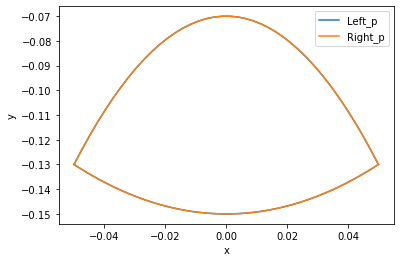

In [13]:
# Left trajectory design
Left_p_on=[0.05,0.13]
Left_p_off=[-0.05,0.13]
Left_p_stance=[0,0.15] # outside
Left_p_swing=[0,0.07] # inside
Left_T=5 # total time
Left_d=0.6
Left_N=100
Left_N_stance = int(Left_N * (Left_d))
Left_N_swing = int(Left_N * (1-Left_d))
[Left_x_desired, Left_y_desired, Left_thetaR_desired, Left_thetaL_desired, Left_t_desired]= gaits_points(
                                Left_p_on, Left_p_off, 
                                Left_p_stance, Left_p_swing, 
                                Left_T, Left_d, Left_N)
# Left Rise trajectory design
Left_Rise_N=20
[Left_Rise_x_desired, Left_Rise_y_desired, Left_Rise_thetaR_desired, Left_Rise_thetaL_desired, Left_Rise_t_desired]= gaits_points_rise( 
                                Left_p_stance, Left_p_swing, Left_Rise_N)
# Right trajectory design
offset=[0,0]
Right_p_on=[Left_p_off[0]+offset[0],Left_p_off[1]+offset[1]]
Right_p_off=[Left_p_on[0]+offset[0],Left_p_on[1]+offset[1]]
Right_p_stance=[Left_p_stance[0]+offset[0],Left_p_stance[1]+offset[1]] # outside
Right_p_swing=Left_p_swing # inside
Right_T=Left_T # total time
Right_d=Left_d
Right_N=Left_N
Right_N_stance = int(Right_N * (Right_d))
Right_N_swing = int(Right_N * (1-Right_d))
[Right_x_desired, Right_y_desired, Right_thetaR_desired, Right_thetaL_desired, Right_t_desired]= gaits_points(
                                Right_p_on, Right_p_off, 
                                Right_p_stance, Right_p_swing,
                                Right_T, Right_d, Right_N)
# Right Rise trajectory design
Right_Rise_N=Left_Rise_N
[Right_Rise_x_desired, Right_Rise_y_desired, Right_Rise_thetaR_desired, Right_Rise_thetaL_desired, Right_Rise_t_desired]= gaits_points_rise( 
                                Right_p_stance, Right_p_swing, Right_Rise_N)

# plot xy
plt.clf()
Left_p,=plt.plot(-Left_x_desired, -Left_y_desired, label='Left_p')
Right_p,=plt.plot(-Right_x_desired, -Right_y_desired, label='Right_p')
plt.legend(handles=[Left_p,Right_p])
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('All_xy.png')

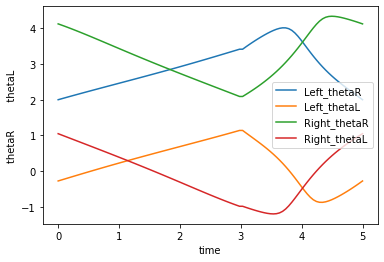

In [84]:
# plot theta
plt.clf()
mpl.rcParams['lines.markersize'] = 3
Left_thetaR,=plt.plot(Left_t_desired, Left_thetaR_desired, label='Left_thetaR')
Left_thetaL,=plt.plot(Left_t_desired, Left_thetaL_desired, label='Left_thetaL')
Right_thetaR,=plt.plot(Right_t_desired, Right_thetaR_desired, label='Right_thetaR')
Right_thetaL,=plt.plot(Right_t_desired, Right_thetaL_desired, label='Right_thetaL')
plt.legend(handles=[Left_thetaR, Left_thetaL, Right_thetaR, Right_thetaL])
plt.xlabel('time')
plt.ylabel('thetaR         thetaL')
plt.savefig('All_theta.png')

# Check All starting position

# Test walking position control with detection

In [155]:
# move or not?
motion=1
detect=1
detect_value=20 #degree

# Left trajectory design
Left_p_on=[0.08,0.13]
Left_p_off=[-0.08,0.13]
Left_p_stance=[0,0.15] # outside
Left_p_swing=[0,0.07] # inside
Left_T=5 # total time
Left_d=0.6
Left_N=100
Left_N_stance = int(Left_N * (Left_d))
Left_N_swing = int(Left_N * (1-Left_d))
[Left_x_desired, Left_y_desired, Left_thetaR_desired, Left_thetaL_desired, Left_t_desired]= gaits_points(
                                Left_p_on, Left_p_off, 
                                Left_p_stance, Left_p_swing, 
                                Left_T, Left_d, Left_N)
# Left Rise trajectory design
Left_Rise_N=20
[Left_Rise_x_desired, Left_Rise_y_desired, Left_Rise_thetaR_desired, Left_Rise_thetaL_desired, Left_Rise_t_desired]= gaits_points_rise( 
                                Left_p_stance, Left_p_swing, Left_Rise_N)
# Right trajectory design
offset=[0,0]
Right_p_on=[Left_p_off[0]+offset[0],Left_p_off[1]+offset[1]]
Right_p_off=[Left_p_on[0]+offset[0],Left_p_on[1]+offset[1]]
Right_p_stance=[Left_p_stance[0]+offset[0],Left_p_stance[1]+offset[1]] # outside
Right_p_swing=Left_p_swing # inside
Right_T=Left_T # total time
Right_d=Left_d
Right_N=Left_N
Right_N_stance = int(Right_N * (Right_d))
Right_N_swing = int(Right_N * (1-Right_d))
[Right_x_desired, Right_y_desired, Right_thetaR_desired, Right_thetaL_desired, Right_t_desired]= gaits_points(
                                Right_p_on, Right_p_off, 
                                Right_p_stance, Right_p_swing,
                                Right_T, Right_d, Right_N)
# Right Rise trajectory design
Right_Rise_N=Left_Rise_N
[Right_Rise_x_desired, Right_Rise_y_desired, Right_Rise_thetaR_desired, Right_Rise_thetaL_desired, Right_Rise_t_desired]= gaits_points_rise( 
                                Right_p_stance, Right_p_swing, Right_Rise_N)
#=====================================================================================
# Initial value
#=====================================================================================
# define position
Left_pos_error=[]
Left_pos_L_error =[]
Left_pos_R_error =[]
Right_pos_error =[]
Right_pos_L_error =[]
Right_pos_R_error =[]
Right_theta_R_error_detect_empty=[]

Left_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Left_m0_home_pos) for i in Left_thetaR_desired];   
Left_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Left_m1_home_pos) for i in Left_thetaL_desired];
Right_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_thetaR_desired];   
Right_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_thetaL_desired];
Left_Rise_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Left_m0_home_pos) for i in Left_Rise_thetaR_desired];   
Left_Rise_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Left_m1_home_pos) for i in Left_Rise_thetaL_desired];
Right_Rise_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_Rise_thetaR_desired];   
Right_Rise_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_Rise_thetaL_desired];

# define current
Left_current=[]
Left_current_R=[]
Left_current_L=[]
Right_current=[]
Right_current_R=[]
Right_current_L=[]
# define time
Left_t_curr=[]
Right_t_curr=[]
marker_t_curr=[]

# define phase
Left_phase=[]
Right_phase=[]



i=0#(0~99)
steps = 0
if motion == 1:
    odrv_Left.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Left.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Right.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Right.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
start = time.time()
#=====================================================================================
# Initial Rise 
#=====================================================================================
# Both in swing(stand lower)    
# Left: p_swing, Right:p_swing

Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1]        
Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1]
Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1]        
Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1]
if motion == 1:
    [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                             Left_pos_L_temp,
                                                                             Right_pos_R_temp,
                                                                             Right_pos_L_temp)
    #record value
    Left_t_curr.append(time.time() - start) 
    Right_t_curr.append(time.time() - start) 
    Left_pos_R_error.append(Left_pos_error[0])
    Left_pos_L_error.append(Left_pos_error[1])
    Right_pos_R_error.append(Right_pos_error[0])
    Right_pos_L_error.append(Right_pos_error[1])
    Left_current_R.append(Left_current[0])
    Left_current_L.append(Left_current[1])
    Right_current_R.append(Right_current[0])
    Right_current_L.append(Right_current[1])
    Left_phase.append(0)
    Right_phase.append(0)
    # detect hit
    Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
    # calculate y
    if Right_theta_R_error_detect>detect_value:
        marker_t_curr.append(len(Right_t_curr)-1) 
        # offset = [0,y]
        # new trajectory
        
# time gap
time.sleep(3)    

# Both in stance(stand higher)   
# Left: p_swing-> p_stance, Right: p_swing-> p_stance
for i in range(Left_Rise_N):
    Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1-i]        
    Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1-i]
    Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1-i]        
    Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1-i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>detect_value:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap
    time.sleep(0.01)
    

# Rise Right leg 
# Left: mid stance, Right: mid stance -> mid swing
for i in range(Left_Rise_N):
    Left_pos_L_temp = Left_Rise_pos_L[0]        
    Left_pos_R_temp = Left_Rise_pos_R[0]
    Right_pos_L_temp = Right_Rise_pos_L[i]        
    Right_pos_R_temp = Right_Rise_pos_R[i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>detect_value:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap
    time.sleep(0.01)
    
#=====================================================================================
# Walking loops
#=====================================================================================    
# Left_N_stance = Right_N_stance 
# Left_N_swing = Right_N_swing
# Right leg forward, Left leg backward
# Left: p_stance -> p_off, Right: p_swing -> p_on
# Left: 30~49, Right: 80~99
steps = int(Left_N/2) #50
prepare_stance = int(Left_N_stance/2) #30
prepare_swing = int(Left_N_swing/2) #20
loops = 3
for i in range(prepare_swing):#0~19
    Left_pos_R_temp = Left_pos_R[i+prepare_stance] #30~49
    Left_pos_L_temp = Left_pos_L[i+prepare_stance]       
    Right_pos_R_temp = Right_pos_R[i+steps+prepare_stance] #80~99
    Right_pos_L_temp = Right_pos_L[i+steps+prepare_stance]   
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(5)
        Right_phase.append(-5)
        # detect hit
        
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        Right_theta_L_error_detect =np.rad2deg(- ((Right_pos_error[1]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>detect_value:
            marker_t_curr.append(len(Right_t_curr)-1) 
            # offset = [0,y]
            # new trajectory
    # time gap between loop
    time.sleep(0.01)
    
for j in range(loops):
    # Left: swing 50~99, Right: stance 0~49
    for i in range(steps):
        Left_pos_R_temp = Left_pos_R[i+steps]
        Left_pos_L_temp = Left_pos_L[i+steps]        
        Right_pos_R_temp = Right_pos_R[i]
        Right_pos_L_temp = Right_pos_L[i]    
        if motion == 1:
            [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                     Left_pos_L_temp,
                                                                                     Right_pos_R_temp,
                                                                                     Right_pos_L_temp)
            #record value
            Left_t_curr.append(time.time() - start) 
            Right_t_curr.append(time.time() - start) 
            Left_pos_R_error.append(Left_pos_error[0])
            Left_pos_L_error.append(Left_pos_error[1])
            Right_pos_R_error.append(Right_pos_error[0])
            Right_pos_L_error.append(Right_pos_error[1])
            Left_current_R.append(Left_current[0])
            Left_current_L.append(Left_current[1])
            Right_current_R.append(Right_current[0])
            Right_current_L.append(Right_current[1])
            Left_phase.append(-5)
            Right_phase.append(5)
            # detect hit
            Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
            Right_theta_R_error_detect_empty.append(Right_theta_R_error_detect)
            # calculate y
            if Right_theta_R_error_detect>detect_value:
                marker_t_curr.append(len(Right_t_curr)-1)
                if detect == 1:
                    # record position
                    Right_R_encoder_pos_detect = odrv_Right.axis0.encoder.pos_estimate
                    Right_L_encoder_pos_detect = odrv_Right.axis1.encoder.pos_estimate 
                    Right_thetaR_detect = - ((Right_R_encoder_pos_detect - Right_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
                    Right_thetaL_detect = - ((Right_L_encoder_pos_detect - Right_m1_home_pos) / 8192 * 2 * np.pi)
                    Right_x_detect,Right_y_detect = FK_fast(Right_thetaR_detect, Right_thetaL_detect)
                    # new Right trajectory design
                    offset=[0,float((Right_y_detect-0.02)-Left_p_on[1])]
                    Right_p_on=[Left_p_off[0]+offset[0],Left_p_off[1]+offset[1]]
                    Right_p_off=[Left_p_on[0]+offset[0],Left_p_on[1]+offset[1]]
                    Right_p_stance=[Left_p_stance[0]+offset[0],Left_p_stance[1]+offset[1]] # outside
                    Right_p_swing=Left_p_swing # inside
                    Right_T=Left_T # total time
                    Right_d=Left_d
                    Right_N=Left_N
                    Right_N_stance = int(Right_N * (Right_d))
                    Right_N_swing = int(Right_N * (1-Right_d))
                    [Right_x_desired, Right_y_desired, Right_thetaR_desired, Right_thetaL_desired, Right_t_desired]= gaits_points(
                                                    Right_p_on, Right_p_off, 
                                                    Right_p_stance, Right_p_swing,
                                                    Right_T, Right_d, Right_N)
                    # Right Rise trajectory design
                    Right_Rise_N=Left_Rise_N
                    [Right_Rise_x_desired, Right_Rise_y_desired, Right_Rise_thetaR_desired, Right_Rise_thetaL_desired, Right_Rise_t_desired]= gaits_points_rise( 
                                                    Right_p_stance, Right_p_swing, Right_Rise_N)
                    Right_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_thetaR_desired];   
                    Right_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_thetaL_desired];
                    Right_Rise_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_Rise_thetaR_desired];   
                    Right_Rise_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_Rise_thetaL_desired];
        
        # time gap between loop
        time.sleep(0.01)
        
#     if np.amax(Right_theta_R_error_detect_empty)<18 and detect == 1 :
#         marker_t_curr.append(len(Right_t_curr)-1)
#         print(Right_theta_R_error_detect_empty)
#         # old Right trajectory design
#         offset=[0,-offset[1]]
#         Right_p_on=[Left_p_off[0]+offset[0],Left_p_off[1]+offset[1]]
#         Right_p_off=[Left_p_on[0]+offset[0],Left_p_on[1]+offset[1]]
#         Right_p_stance=[Left_p_stance[0]+offset[0],Left_p_stance[1]+offset[1]] # outside
#         Right_p_swing=Left_p_swing # inside
#         Right_T=Left_T # total time
#         Right_d=Left_d
#         Right_N=Left_N
#         Right_N_stance = int(Right_N * (Right_d))
#         Right_N_swing = int(Right_N * (1-Right_d))
#         [Right_x_desired, Right_y_desired, Right_thetaR_desired, Right_thetaL_desired, Right_t_desired]= gaits_points(
#                                         Right_p_on, Right_p_off, 
#                                         Right_p_stance, Right_p_swing,
#                                         Right_T, Right_d, Right_N)
#         # Right Rise trajectory design
#         Right_Rise_N=Left_Rise_N
#         [Right_Rise_x_desired, Right_Rise_y_desired, Right_Rise_thetaR_desired, Right_Rise_thetaL_desired, Right_Rise_t_desired]= gaits_points_rise( 
#                                         Right_p_stance, Right_p_swing, Right_Rise_N)
#         Right_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_thetaR_desired];   
#         Right_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_thetaL_desired];
#         Right_Rise_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_Rise_thetaR_desired];   
#         Right_Rise_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_Rise_thetaL_desired];
#         Right_theta_R_error_detect_empty=[]
    # Left: 0~49, Right: swing 50~99
    for i in range(steps):
        Left_pos_R_temp = Left_pos_R[i]
        Left_pos_L_temp = Left_pos_L[i] 
        Right_pos_R_temp = Right_pos_R[i+steps]
        Right_pos_L_temp = Right_pos_L[i+steps]   
        if motion == 1:
            [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                     Left_pos_L_temp,
                                                                                     Right_pos_R_temp,
                                                                                     Right_pos_L_temp)
            #record value
            Left_t_curr.append(time.time() - start) 
            Right_t_curr.append(time.time() - start) 
            Left_pos_R_error.append(Left_pos_error[0])
            Left_pos_L_error.append(Left_pos_error[1])
            Right_pos_R_error.append(Right_pos_error[0])
            Right_pos_L_error.append(Right_pos_error[1])
            Left_current_R.append(Left_current[0])
            Left_current_L.append(Left_current[1])
            Right_current_R.append(Right_current[0])
            Right_current_L.append(Right_current[1])
            Left_phase.append(5)
            Right_phase.append(-5)
            # detect hit
            Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
            if Right_theta_R_error_detect>detect_value:
                marker_t_curr.append(len(Right_t_curr)-1)
        # time gap between loop
        time.sleep(0.01)
        

#=====================================================================================
# Ending
#===================================================================================== 
# Left: stance 50~80, Right: swing 0~30
for i in range(prepare_stance+1):
    Left_pos_L_temp = Left_pos_L[i+steps]        
    Left_pos_R_temp = Left_pos_R[i+steps]
    Right_pos_L_temp = Right_pos_L[i]        
    Right_pos_R_temp = Right_pos_R[i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>detect_value:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap between loop
    time.sleep(0.01)
# Left: 80, Right:30->80
for i in range(Right_Rise_N-1):
    Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1]        
    Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1]
    Right_pos_L_temp = Right_Rise_pos_L[i]        
    Right_pos_R_temp = Right_Rise_pos_R[i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>detect_value:
            marker_t_curr.append(len(Right_t_curr)-1) 
            
    # time gap
    time.sleep(0.01)
# Both in swing(stand lower)    
# Left: 80, Right:80
Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1]        
Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1]
Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1]        
Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1]
if motion == 1:
    [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                             Left_pos_L_temp,
                                                                             Right_pos_R_temp,
                                                                             Right_pos_L_temp)
    #record value
    Left_t_curr.append(time.time() - start) 
    Right_t_curr.append(time.time() - start) 
    Left_pos_R_error.append(Left_pos_error[0])
    Left_pos_L_error.append(Left_pos_error[1])
    Right_pos_R_error.append(Right_pos_error[0])
    Right_pos_L_error.append(Right_pos_error[1])
    Left_current_R.append(Left_current[0])
    Left_current_L.append(Left_current[1])
    Right_current_R.append(Right_current[0])
    Right_current_L.append(Right_current[1])
    Left_phase.append(0)
    Right_phase.append(0)
    # detect hit
    Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
    if Right_theta_R_error_detect>detect_value:
        marker_t_curr.append(len(Right_t_curr)-1) 
# time gap
time.sleep(8)

# Both in stance(stand higher)    
# Left: 80->30, Right:80->30
for i in range(Right_Rise_N-1):
    Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1-i]        
    Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1-i]
    Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1-i]        
    Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1-i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>detect_value:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap
    time.sleep(0.01)
# time gap
time.sleep(2)    
if motion == 1:
    odrv_Left.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
    odrv_Left.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE     
    odrv_Right.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
    odrv_Right.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

In [156]:
print(offset)

[0, 0]


In [316]:
odrv_Left.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv_Left.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE     
odrv_Right.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
odrv_Right.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

# Test walking position control

In [303]:
#=====================================================================================
# Initial value
#=====================================================================================
# move or not?
motion=1
# define position
Left_pos_error=[]
Left_pos_L_error =[]
Left_pos_R_error =[]
Right_pos_error =[]
Right_pos_L_error =[]
Right_pos_R_error =[]

Left_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Left_m0_home_pos) for i in Left_thetaR_desired];   
Left_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Left_m1_home_pos) for i in Left_thetaL_desired];
Right_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_thetaR_desired];   
Right_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_thetaL_desired];
Left_Rise_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Left_m0_home_pos) for i in Left_Rise_thetaR_desired];   
Left_Rise_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Left_m1_home_pos) for i in Left_Rise_thetaL_desired];
Right_Rise_pos_R=[ ((-(i-np.pi)/(2*np.pi) * 8192) + Right_m0_home_pos) for i in Right_Rise_thetaR_desired];   
Right_Rise_pos_L=[ ((-(i)/(2*np.pi) * 8192) + Right_m1_home_pos) for i in Right_Rise_thetaL_desired];

# define current
Left_current=[]
Left_current_R=[]
Left_current_L=[]
Right_current=[]
Right_current_R=[]
Right_current_L=[]
# define time
Left_t_curr=[]
Right_t_curr=[]
marker_t_curr=[]

# define phase
Left_phase=[]
Right_phase=[]



i=0#(0~99)
steps = 0
if motion == 1:
    odrv_Left.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Left.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Right.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Right.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
start = time.time()
#=====================================================================================
# Initial Rise 
#=====================================================================================
# Both in swing(stand lower)    
# Left: p_swing, Right:p_swing

Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1]        
Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1]
Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1]        
Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1]
if motion == 1:
    [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                             Left_pos_L_temp,
                                                                             Right_pos_R_temp,
                                                                             Right_pos_L_temp)
    #record value
    Left_t_curr.append(time.time() - start) 
    Right_t_curr.append(time.time() - start) 
    Left_pos_R_error.append(Left_pos_error[0])
    Left_pos_L_error.append(Left_pos_error[1])
    Right_pos_R_error.append(Right_pos_error[0])
    Right_pos_L_error.append(Right_pos_error[1])
    Left_current_R.append(Left_current[0])
    Left_current_L.append(Left_current[1])
    Right_current_R.append(Right_current[0])
    Right_current_L.append(Right_current[1])
    Left_phase.append(0)
    Right_phase.append(0)
    # detect hit
    Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
    # calculate y
    if Right_theta_R_error_detect>55:
        marker_t_curr.append(len(Right_t_curr)-1) 
        # offset = [0,y]
# time gap
time.sleep(3)    

# Both in stance(stand higher)   
# Left: p_swing-> p_stance, Right: p_swing-> p_stance
for i in range(Left_Rise_N):
    Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1-i]        
    Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1-i]
    Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1-i]        
    Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1-i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>55:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap
    time.sleep(0.01)
    

# Rise Right leg 
# Left: mid stance, Right: mid stance -> mid swing
for i in range(Left_Rise_N):
    Left_pos_L_temp = Left_Rise_pos_L[0]        
    Left_pos_R_temp = Left_Rise_pos_R[0]
    Right_pos_L_temp = Right_Rise_pos_L[i]        
    Right_pos_R_temp = Right_Rise_pos_R[i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>55:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap
    time.sleep(0.01)
    
#=====================================================================================
# Walking loops
#=====================================================================================    
# Left_N_stance = Right_N_stance 
# Left_N_swing = Right_N_swing
# Right leg forward, Left leg backward
# Left: p_stance -> p_off, Right: p_swing -> p_on
# Left: 30~49, Right: 80~99
steps = int(Left_N/2) #50
prepare_stance = int(Left_N_stance/2) #30
prepare_swing = int(Left_N_swing/2) #20
loops = 3
for i in range(prepare_swing):#0~19
    Left_pos_R_temp = Left_pos_R[i+prepare_stance] #30~49
    Left_pos_L_temp = Left_pos_L[i+prepare_stance]       
    Right_pos_R_temp = Right_pos_R[i+steps+prepare_stance] #80~99
    Right_pos_L_temp = Right_pos_L[i+steps+prepare_stance]   
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(5)
        Right_phase.append(-5)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>50:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap between loop
    time.sleep(0.01)
    
for j in range(loops):
    # Left: swing 50~99, Right: stance 0~49
    for i in range(steps):
        Left_pos_R_temp = Left_pos_R[i+steps]
        Left_pos_L_temp = Left_pos_L[i+steps]        
        Right_pos_R_temp = Right_pos_R[i]
        Right_pos_L_temp = Right_pos_L[i]    
        if motion == 1:
            [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                     Left_pos_L_temp,
                                                                                     Right_pos_R_temp,
                                                                                     Right_pos_L_temp)
            #record value
            Left_t_curr.append(time.time() - start) 
            Right_t_curr.append(time.time() - start) 
            Left_pos_R_error.append(Left_pos_error[0])
            Left_pos_L_error.append(Left_pos_error[1])
            Right_pos_R_error.append(Right_pos_error[0])
            Right_pos_L_error.append(Right_pos_error[1])
            Left_current_R.append(Left_current[0])
            Left_current_L.append(Left_current[1])
            Right_current_R.append(Right_current[0])
            Right_current_L.append(Right_current[1])
            Left_phase.append(-5)
            Right_phase.append(5)
            # detect hit
            Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
            if Right_theta_R_error_detect>55:
                marker_t_curr.append(len(Right_t_curr)-1) 
        # time gap between loop
        time.sleep(0.01)
    # Left: 0~49, Right: swing 50~99
    for i in range(steps):
        Left_pos_R_temp = Left_pos_R[i]
        Left_pos_L_temp = Left_pos_L[i] 
        Right_pos_R_temp = Right_pos_R[i+steps]
        Right_pos_L_temp = Right_pos_L[i+steps]   
        if motion == 1:
            [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                     Left_pos_L_temp,
                                                                                     Right_pos_R_temp,
                                                                                     Right_pos_L_temp)
            #record value
            Left_t_curr.append(time.time() - start) 
            Right_t_curr.append(time.time() - start) 
            Left_pos_R_error.append(Left_pos_error[0])
            Left_pos_L_error.append(Left_pos_error[1])
            Right_pos_R_error.append(Right_pos_error[0])
            Right_pos_L_error.append(Right_pos_error[1])
            Left_current_R.append(Left_current[0])
            Left_current_L.append(Left_current[1])
            Right_current_R.append(Right_current[0])
            Right_current_L.append(Right_current[1])
            Left_phase.append(5)
            Right_phase.append(-5)
            # detect hit
            Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
            if Right_theta_R_error_detect>55:
                marker_t_curr.append(len(Right_t_curr)-1) 
        # time gap between loop
        time.sleep(0.01)
        

#=====================================================================================
# Ending
#===================================================================================== 
# Left: stance 50~80, Right: swing 0~30
for i in range(prepare_stance+1):
    Left_pos_L_temp = Left_pos_L[i+steps]        
    Left_pos_R_temp = Left_pos_R[i+steps]
    Right_pos_L_temp = Right_pos_L[i]        
    Right_pos_R_temp = Right_pos_R[i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>55:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap between loop
    time.sleep(0.01)
# Left: 80, Right:30->80
for i in range(Right_Rise_N-1):
    Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1]        
    Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1]
    Right_pos_L_temp = Right_Rise_pos_L[i]        
    Right_pos_R_temp = Right_Rise_pos_R[i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>55:
            marker_t_curr.append(len(Right_t_curr)-1) 
            
    # time gap
    time.sleep(0.01)
# Both in swing(stand lower)    
# Left: 80, Right:80
Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1]        
Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1]
Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1]        
Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1]
if motion == 1:
    [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                             Left_pos_L_temp,
                                                                             Right_pos_R_temp,
                                                                             Right_pos_L_temp)
    #record value
    Left_t_curr.append(time.time() - start) 
    Right_t_curr.append(time.time() - start) 
    Left_pos_R_error.append(Left_pos_error[0])
    Left_pos_L_error.append(Left_pos_error[1])
    Right_pos_R_error.append(Right_pos_error[0])
    Right_pos_L_error.append(Right_pos_error[1])
    Left_current_R.append(Left_current[0])
    Left_current_L.append(Left_current[1])
    Right_current_R.append(Right_current[0])
    Right_current_L.append(Right_current[1])
    Left_phase.append(0)
    Right_phase.append(0)
    # detect hit
    Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
    if Right_theta_R_error_detect>55:
        marker_t_curr.append(len(Right_t_curr)-1) 
# time gap
time.sleep(8)

# Both in stance(stand higher)    
# Left: 80->30, Right:80->30
for i in range(Right_Rise_N-1):
    Left_pos_L_temp = Left_Rise_pos_L[Left_Rise_N-1-i]        
    Left_pos_R_temp = Left_Rise_pos_R[Left_Rise_N-1-i]
    Right_pos_L_temp = Right_Rise_pos_L[Right_Rise_N-1-i]        
    Right_pos_R_temp = Right_Rise_pos_R[Right_Rise_N-1-i]
    if motion == 1:
        [Left_pos_error,Right_pos_error,Left_current,Right_current]=move_measure(Left_pos_R_temp,
                                                                                 Left_pos_L_temp,
                                                                                 Right_pos_R_temp,
                                                                                 Right_pos_L_temp)
        #record value
        Left_t_curr.append(time.time() - start) 
        Right_t_curr.append(time.time() - start) 
        Left_pos_R_error.append(Left_pos_error[0])
        Left_pos_L_error.append(Left_pos_error[1])
        Right_pos_R_error.append(Right_pos_error[0])
        Right_pos_L_error.append(Right_pos_error[1])
        Left_current_R.append(Left_current[0])
        Left_current_L.append(Left_current[1])
        Right_current_R.append(Right_current[0])
        Right_current_L.append(Right_current[1])
        Left_phase.append(0)
        Right_phase.append(0)
        # detect hit
        Right_theta_R_error_detect = np.rad2deg(- ((Right_pos_error[0]) / 8192 * 2 * np.pi))
        if Right_theta_R_error_detect>55:
            marker_t_curr.append(len(Right_t_curr)-1) 
    # time gap
    time.sleep(0.01)
if motion == 1:
    odrv_Left.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
    odrv_Left.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE     
    odrv_Right.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
    odrv_Right.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE 

# Plot POS Error 

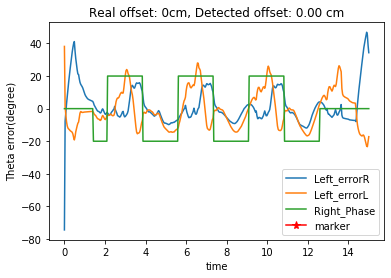

In [157]:
situation = "d0.6_Rhigh_detect"
hight="0"
Left_theta_R_error = [(- ((i) / 8192 * 2 * np.pi))for i in Left_pos_R_error];   
Left_theta_L_error = [(- ((i) / 8192 * 2 * np.pi)) for i in Left_pos_L_error];   
Right_theta_R_error = [(- ((i) / 8192 * 2 * np.pi))for i in Right_pos_R_error];   
Right_theta_L_error = [(- ((i) / 8192 * 2 * np.pi)) for i in Right_pos_L_error]; 
Left_phase_theta = [(i*4)for i in Left_phase]; 
Right_phase_theta = [(i*4)for i in Right_phase];   
Left_phase_y = [(i/5*Left_p_on[1])for i in Left_phase]; 
Right_phase_y = [(i/5*Left_p_on[1])for i in Right_phase]; 


Left_theta_R_error_d = np.rad2deg(Left_theta_R_error)
Left_theta_L_error_d = np.rad2deg(Left_theta_L_error)
Right_theta_R_error_d = np.rad2deg(Right_theta_R_error)
Right_theta_L_error_d = np.rad2deg(Right_theta_L_error)
Left_t= np.linspace(0,Left_T*loops,Left_theta_R_error_d.shape[0])
Right_t= np.linspace(0,Right_T*loops,Right_theta_R_error_d.shape[0])
# Left_t= np.linspace(0,Left_N*3+50,Left_N*3+50)
# Right_t= np.linspace(50,Right_N*3+50,Right_N*3)
markers_index =  [Left_t[i]for i in marker_t_curr]; 
markers_value =  [Left_theta_R_error_d[i]for i in marker_t_curr]; 

plt.clf()
mpl.rcParams['lines.markersize'] = 3
Left_errorR,=plt.plot(Left_t, Left_theta_R_error_d, label='Left_errorR')
Left_errorL,=plt.plot(Left_t, Left_theta_L_error_d, label='Left_errorL')
marker,=plt.plot(markers_index, markers_value, markersize=8, marker='*', color="red", label='marker')
# Right_errorR,=plt.plot(Right_t, Right_theta_R_error_d, label='Right_errorR')
# Right_errorL,=plt.plot(Right_t, Right_theta_L_error_d, label='Right_errorL')
Right_Phase_theta,=plt.plot(Right_t, Right_phase_theta, label='Right_Phase')
plt.legend(handles=[Left_errorR, Left_errorL,Right_Phase_theta,marker])
# plt.legend(handles=[Left_errorR, Left_errorL, Right_errorR, Right_errorL])
plt.title("Real offset: "+hight+"cm, Detected offset: "+str(format((-offset[1]*100),'.2f')+" cm"))
plt.xlabel('time')
plt.ylabel('Theta error(degree)')
plt.savefig('Left_'+situation+'_'+hight+'cm_theta.png')
#plt.savefig('5_error_force.png')

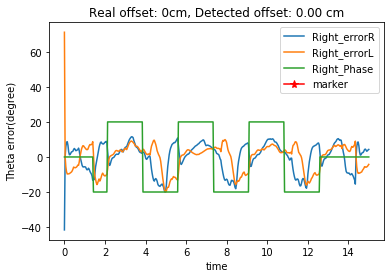

In [158]:
markers_index =  [Right_t[i]for i in marker_t_curr]; 
markers_value =  [Right_theta_R_error_d[i]for i in marker_t_curr]; 
plt.clf()
mpl.rcParams['lines.markersize'] = 3
Right_errorR,=plt.plot(Right_t, Right_theta_R_error_d, label='Right_errorR')
Right_errorL,=plt.plot(Right_t, Right_theta_L_error_d, label='Right_errorL')
Right_Phase_theta,=plt.plot(Right_t, Right_phase_theta, label='Right_Phase')
marker,=plt.plot(markers_index, markers_value, markersize=8,  marker='*' ,color="red", label='marker')
plt.legend(handles=[Right_errorR, Right_errorL, Right_Phase_theta, marker])
plt.title("Real offset: "+hight+"cm, Detected offset: "+str(format((-offset[1]*100),'.2f')+" cm"))
plt.xlabel('time')
plt.ylabel('Theta error(degree)')
plt.savefig('Right_'+situation+'_'+hight+'cm_theta.png')
#plt.savefig('5_error_force.png')

# Plot Current Error 

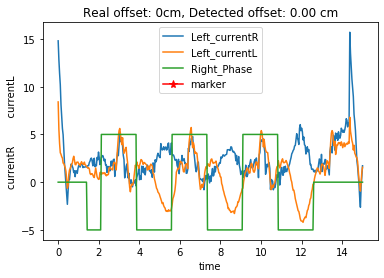

In [159]:
Left_t= np.linspace(0,Left_T*loops,len(Left_current_R))
Right_t= np.linspace(0,Right_T*loops,len(Right_current_L))
markers_index =  [Left_t[i]for i in marker_t_curr]; 
markers_value =  [Left_current_L[i]for i in marker_t_curr]; 

plt.clf()
mpl.rcParams['lines.markersize'] = 3
Left_currentR,=plt.plot(Left_t, Left_current_R, label='Left_currentR')
Left_currentL,=plt.plot(Left_t, Left_current_L, label='Left_currentL')
Right_Phase,=plt.plot(Right_t, Right_phase, label='Right_Phase')
marker,=plt.plot(markers_index, markers_value, markersize=8,  marker='*', color="red", label='marker')
plt.legend(handles=[Left_currentR,Left_currentL,Right_Phase,marker])
plt.title("Real offset: "+hight+"cm, Detected offset: "+str(format((-offset[1]*100),'.2f')+" cm"))
plt.xlabel('time')
plt.ylabel('currentR         currentL')
plt.savefig('Left_'+situation+'_'+hight+'cm_current.png')

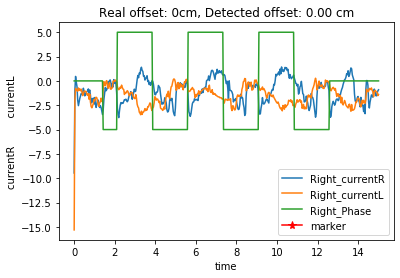

In [160]:
markers_index =  [Right_t[i]for i in marker_t_curr]; 
markers_value =  [Right_current_L[i]for i in marker_t_curr];
plt.clf()
mpl.rcParams['lines.markersize'] = 3
Right_currentR,=plt.plot(Right_t, Right_current_R, label='Right_currentR')
Right_currentL,=plt.plot(Right_t, Right_current_L, label='Right_currentL')
Right_Phase,=plt.plot(Right_t, Right_phase, label='Right_Phase')
marker,=plt.plot(markers_index, markers_value, markersize=8,  marker='*', color="red", label='marker')
plt.legend(handles=[Right_currentR,Right_currentL,Right_Phase,marker])
plt.title("Real offset: "+hight+"cm, Detected offset: "+str(format((-offset[1]*100),'.2f')+" cm"))
plt.xlabel('time')
plt.ylabel('currentR         currentL')
plt.savefig('Right_'+situation+'_'+hight+'cm_current.png')

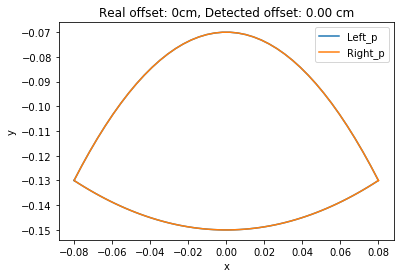

In [161]:
# plot xy
plt.clf()
Left_p,=plt.plot(-Left_x_desired, -Left_y_desired, label='Left_p')
Right_p,=plt.plot(-Right_x_desired, -Right_y_desired, label='Right_p')
plt.legend(handles=[Left_p,Right_p])
plt.title("Real offset: "+hight+"cm, Detected offset: "+str(format((-offset[1]*100),'.2f')+" cm"))
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Right_'+situation+'_'+hight+'cm_trajectory.png')

# Plot xy error

# Test Left position control

# Test Right position control

# Test All position control

# Animate trajectory

# Define cartesian compliance and SMD function

In [13]:
def cartesian_compliance(k_c, c_c, theta_R, theta_L, vel_R, vel_L, theta_R_temp, theta_L_temp):
    # R=m0, L=m1 
    # stiffness coeff
    kx = k_c[0]
    ky = k_c[1]
    k = np.array([[kx,0],[0,ky]])
    # damping coeff
    cx = c_c[0]
    cy = c_c[1]
    c = np.array([[cx,0],[0,cy]])
    # motor torque const
    Kt = 0.0285
    J_trans = -np.transpose(J_fast(theta_R, theta_L))
    disp = FK_fast(theta_R, theta_L) - FK_fast(theta_R_temp, theta_L_temp)
    vel = J_fast(theta_R, theta_L) @ np.array([[vel_R], [vel_L]])  
    currents = J_trans @ ( k @ disp + c @ vel )*(1/Kt)
    return currents 

# SMD for Left Leg
def cartesian_Left_SMD (Left_k, Left_c, Left_theta_R_temp, Left_theta_L_temp, Left_duration):
    odrv_Left.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Left.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    t0 = 0
    t1 = 0
    t_start = time.time()
    count = 0
    current_Left_M0 = []
    current_Left_M1 = []
    timestamp = []
    while (time.time() - t_start < Left_duration):
        t0 = time.time()
        #read the encoder position & velocity
        Left_m0_encoder_pos = odrv_Left.axis0.encoder.pos_estimate
        Left_m1_encoder_pos = odrv_Left.axis1.encoder.pos_estimate
        Left_m0_encoder_vel = odrv_Left.axis0.encoder.vel_estimate
        Left_m1_encoder_vel = odrv_Left.axis1.encoder.vel_estimate
        #current angle(rad) & velocity(rad/s)
        Left_theta_R = - ((Left_m0_encoder_pos - Left_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
        Left_theta_L = - ((Left_m1_encoder_pos - Left_m1_home_pos) / 8192 * 2 * np.pi)
        Left_vel_R = - ((Left_m0_encoder_vel) / 8192 * 2 * np.pi)
        Left_vel_L = - ((Left_m1_encoder_vel) / 8192 * 2 * np.pi)
        #get cureent
        Left_current = cartesian_compliance(Left_k, Left_c, 
                                       Left_theta_R, Left_theta_L, 
                                       Left_vel_R, Left_vel_L, 
                                       Left_theta_R_temp, Left_theta_L_temp)
        Left_damping_R = 0.5
        Left_damping_L = 0.5
        Left_damping_m0 = np.array(Left_damping_R * Left_vel_R)
        Left_damping_m1 = np.array(Left_damping_L * Left_vel_L)
        Left_current_m0 = Left_current[0] - Left_damping_m0
        Left_current_m1 = Left_current[1] - Left_damping_m1
        #make sure the current is not exceeds the limit
        Left_current_R = min(np.abs(Left_current_m0), current_limit_Left[0]) * np.sign(Left_current_m0)
        Left_current_L = min(np.abs(Left_current_m1), current_limit_Left[1]) * np.sign(Left_current_m1)       
        
        #read and record motors current
        timestamp.append(time.time() - t_start)
        current_Left_M0_measure = odrv_Left.axis0.motor.current_control.Iq_measured
        current_Left_M1_measure = odrv_Left.axis1.motor.current_control.Iq_measured 
        current_Left_M0.append(current_Left_M0_measure)
        current_Left_M1.append(current_Left_M1_measure)
        #if np.logical_and(  ( abs(current_Left_M0_test) > 4 ), ( abs(current_Left_M1_test) > 4 ):
        #    reset_eq(reset_point_M0,reset_point_M1)
        
        #control the motors
        odrv_Left.axis0.controller.set_current_setpoint(-Left_current_R)
        odrv_Left.axis1.controller.set_current_setpoint(-Left_current_L)
        t1 = time.time()
        count += 1
    #print(count,'iterations in', duration, 'second')
    #print(count/duration, 'Hz')
    Left_current_data = np.array([current_Left_M0 ,current_Left_M1])
    odrv_Left.axis0.requested_state = AXIS_STATE_IDLE
    odrv_Left.axis1.requested_state = AXIS_STATE_IDLE
    return Left_current_data

# SMD for Right Leg
def cartesian_Right_SMD (Right_k, Right_c, Right_theta_R_temp, Right_theta_L_temp, Right_duration):
    odrv_Right.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Right.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    t0 = 0
    t1 = 0
    t_start = time.time()
    count = 0
    current_Right_M0 = []
    current_Right_M1 = []
    timestamp = []
    while (time.time() - t_start < Right_duration):
        t0 = time.time()
        #read the encoder position & velocity
        Right_m0_encoder_pos = odrv_Right.axis0.encoder.pos_estimate
        Right_m1_encoder_pos = odrv_Right.axis1.encoder.pos_estimate
        Right_m0_encoder_vel = odrv_Right.axis0.encoder.vel_estimate
        Right_m1_encoder_vel = odrv_Right.axis1.encoder.vel_estimate
        #current angle(rad) & velocity(rad/s)
        Right_theta_R = - ((Right_m0_encoder_pos - Right_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
        Right_theta_L = - ((Right_m1_encoder_pos - Right_m1_home_pos) / 8192 * 2 * np.pi)
        Right_vel_R = - ((Right_m0_encoder_vel) / 8192 * 2 * np.pi)
        Right_vel_L = - ((Right_m1_encoder_vel) / 8192 * 2 * np.pi)
        #get cureent
        Right_current = cartesian_compliance(Right_k, Right_c, 
                                       Right_theta_R, Right_theta_L, 
                                       Right_vel_R, Right_vel_L, 
                                       Right_theta_R_temp, Right_theta_L_temp)
        Right_damping_R = 0.5
        Right_damping_L = 0.5
        Right_damping_m0 = np.array(Right_damping_R * Right_vel_R)
        Right_damping_m1 = np.array(Right_damping_L * Right_vel_L)
        Right_current_m0 = Right_current[0] - Right_damping_m0
        Right_current_m1 = Right_current[1] - Right_damping_m1
        #make sure the current is not exceeds the limit
        Right_current_R = min(np.abs(Right_current_m0), current_limit_Right[0]) * np.sign(Right_current_m0)
        Right_current_L = min(np.abs(Right_current_m1), current_limit_Right[1]) * np.sign(Right_current_m1)       
        
        #read and record motors current
        timestamp.append(time.time() - t_start)
        current_Right_M0_measure = odrv_Right.axis0.motor.current_control.Iq_measured
        current_Right_M1_measure = odrv_Right.axis1.motor.current_control.Iq_measured 
        current_Right_M0.append(current_Right_M0_measure)
        current_Right_M1.append(current_Right_M1_measure)
        #if np.logical_and(  ( abs(current_Right_M0_test) > 4 ), ( abs(current_Right_M1_test) > 4 ):
        #    reset_eq(reset_point_M0,reset_point_M1)
        
        #control the motors
        odrv_Right.axis0.controller.set_current_setpoint(-Right_current_R)
        odrv_Right.axis1.controller.set_current_setpoint(-Right_current_L)
        t1 = time.time()
        count += 1
    #print(count,'iterations in', duration, 'second')
    #print(count/duration, 'Hz')
    Right_current_data = np.array([current_Right_M0 ,current_Right_M1])
    odrv_Right.axis0.requested_state = AXIS_STATE_IDLE
    odrv_Right.axis1.requested_state = AXIS_STATE_IDLE
    return Right_current_data

# SMD for All Leg
def cartesian_All_SMD (Left_k, Left_c, Right_k, Right_c, 
                       Left_theta_R_temp, Left_theta_L_temp, Right_theta_R_temp, Right_theta_L_temp, 
                       All_duration):
    odrv_Left.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Left.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Right.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv_Right.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    t0 = 0
    t1 = 0
    t_start = time.time()
    count = 0
    current_Left_M0 = []
    current_Left_M1 = []    
    current_Right_M0 = []
    current_Right_M1 = []
    timestamp = []
    while (time.time() - t_start < All_duration):
        t0 = time.time()
        #read the Left encoder position & velocity
        Left_m0_encoder_pos = odrv_Left.axis0.encoder.pos_estimate
        Left_m1_encoder_pos = odrv_Left.axis1.encoder.pos_estimate
        Left_m0_encoder_vel = odrv_Left.axis0.encoder.vel_estimate
        Left_m1_encoder_vel = odrv_Left.axis1.encoder.vel_estimate
        #read the Right encoder position & velocity
        Right_m0_encoder_pos = odrv_Right.axis0.encoder.pos_estimate
        Right_m1_encoder_pos = odrv_Right.axis1.encoder.pos_estimate
        Right_m0_encoder_vel = odrv_Right.axis0.encoder.vel_estimate
        Right_m1_encoder_vel = odrv_Right.axis1.encoder.vel_estimate

        #current Left angle(rad) & velocity(rad/s)
        Left_theta_R = - ((Left_m0_encoder_pos - Left_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
        Left_theta_L = - ((Left_m1_encoder_pos - Left_m1_home_pos) / 8192 * 2 * np.pi)
        Left_vel_R = - ((Left_m0_encoder_vel) / 8192 * 2 * np.pi)
        Left_vel_L = - ((Left_m1_encoder_vel) / 8192 * 2 * np.pi)        
        #current Right angle(rad) & velocity(rad/s)
        Right_theta_R = - ((Right_m0_encoder_pos - Right_m0_home_pos) / 8192 * 2 * np.pi) + np.pi
        Right_theta_L = - ((Right_m1_encoder_pos - Right_m1_home_pos) / 8192 * 2 * np.pi)
        Right_vel_R = - ((Right_m0_encoder_vel) / 8192 * 2 * np.pi)
        Right_vel_L = - ((Right_m1_encoder_vel) / 8192 * 2 * np.pi)
        
        #get Left cureent
        Left_current = cartesian_compliance(Left_k, Left_c, 
                                       Left_theta_R, Left_theta_L, 
                                       Left_vel_R, Left_vel_L, 
                                       Left_theta_R_temp, Left_theta_L_temp)        
        #get Right cureent
        Right_current = cartesian_compliance(Right_k, Right_c, 
                                       Right_theta_R, Right_theta_L, 
                                       Right_vel_R, Right_vel_L, 
                                       Right_theta_R_temp, Right_theta_L_temp)
        
        Left_damping_R = 0.5
        Left_damping_L = 0.5
        Left_damping_m0 = np.array(Left_damping_R * Left_vel_R)
        Left_damping_m1 = np.array(Left_damping_L * Left_vel_L)
        Left_current_m0 = Left_current[0] - Left_damping_m0
        Left_current_m1 = Left_current[1] - Left_damping_m1        
        Right_damping_R = 0.5
        Right_damping_L = 0.5
        Right_damping_m0 = np.array(Right_damping_R * Right_vel_R)
        Right_damping_m1 = np.array(Right_damping_L * Right_vel_L)
        Right_current_m0 = Right_current[0] - Right_damping_m0
        Right_current_m1 = Right_current[1] - Right_damping_m1
        
        #make sure Left current is not exceeds the limit
        Left_current_R = min(np.abs(Left_current_m0), current_limit_Left[0]) * np.sign(Left_current_m0)
        Left_current_L = min(np.abs(Left_current_m1), current_limit_Left[1]) * np.sign(Left_current_m1)         
        #make sure Right current is not exceeds the limit
        Right_current_R = min(np.abs(Right_current_m0), current_limit_Right[0]) * np.sign(Right_current_m0)
        Right_current_L = min(np.abs(Right_current_m1), current_limit_Right[1]) * np.sign(Right_current_m1)       
        
        #read and record Left legs current
        timestamp.append(time.time() - t_start)
        current_Left_M0_measure = odrv_Left.axis0.motor.current_control.Iq_measured
        current_Left_M1_measure = odrv_Left.axis1.motor.current_control.Iq_measured 
        current_Left_M0.append(current_Left_M0_measure)
        current_Left_M1.append(current_Left_M1_measure)     
        #read and record Right legs current
        current_Right_M0_measure = odrv_Right.axis0.motor.current_control.Iq_measured
        current_Right_M1_measure = odrv_Right.axis1.motor.current_control.Iq_measured 
        current_Right_M0.append(current_Right_M0_measure)
        current_Right_M1.append(current_Right_M1_measure)
        #if np.logical_and(  ( abs(current_Left_M0_test) > 4 ), ( abs(current_Left_M1_test) > 4 ):
        #    reset_eq(reset_point_M0,reset_point_M1)   
        #if np.logical_and(  ( abs(current_Right_M0_test) > 4 ), ( abs(current_Right_M1_test) > 4 ):
        #    reset_eq(reset_point_M0,reset_point_M1)
        
        #control Left legs
        odrv_Left.axis0.controller.set_current_setpoint(-Left_current_R)
        odrv_Left.axis1.controller.set_current_setpoint(-Left_current_L)        
        #control Right legs
        odrv_Right.axis0.controller.set_current_setpoint(-Right_current_R)
        odrv_Right.axis1.controller.set_current_setpoint(-Right_current_L)
        
        t1 = time.time()
        count += 1
    #print(count,'iterations in', duration, 'second')
    #print(count/duration, 'Hz')
    
    All_current_data = np.array([current_Left_M0, current_Left_M1, 
                                   current_Right_M0, current_Right_M1])
    odrv_Left.axis0.requested_state = AXIS_STATE_IDLE
    odrv_Left.axis1.requested_state = AXIS_STATE_IDLE
    odrv_Right.axis0.requested_state = AXIS_STATE_IDLE
    odrv_Right.axis1.requested_state = AXIS_STATE_IDLE
    return All_current_data

# Test cartesian_Left_SMD 

# Test cartesian_Right_SMD 

# Test cartesian_All_SMD 

# Test Left leg SMD walking motion

# Test Right leg SMD walking motion

# Test All legs SMD walking motion

# Test odrive position

# Define odrive code